<a href="https://colab.research.google.com/github/wayuu/modelo_diagnostico_arritmia/blob/main/modelo_MIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os  # Esta línea es necesaria para utilizar las funciones de manejo de archivos y rutas
import wfdb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dense, Flatten, Input, Reshape,  Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Recall, Precision, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy, BinaryAccuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy, BinaryAccuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy, BinaryAccuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy, BinaryAccuracy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt


In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Ruta correcta
base_path = "/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/x_mitdb"
print(os.listdir(base_path))

# Lista de números de registro que deseas cargar
record_numbers = ['109']  # Agrega más números según tus necesidades

# Crear listas para almacenar datos de múltiples registros
all_signals = []
all_annotations = []

for record_number in record_numbers:
    # Construye la ruta para cada archivo
    record_path = os.path.join(base_path, f'x_{record_number}')

    try:
        # Cargar la señal y anotaciones
        record, fields = wfdb.rdsamp(record_path)  # Cargar la señal de ECG
        annotation = wfdb.rdann(record_path, 'atr')  # Cargar anotaciones

        fs = fields['fs']  # Frecuencia de muestreo

        # Agregar los datos al DataFrame para cada registro
        df_signal = pd.DataFrame(record, columns=['Canal_1', 'Canal_2'])
        df_signal['Muestra'] = range(len(df_signal))  # Añadir el índice de muestra
        df_signal['Registro'] = record_number  # Añadir columna de número de registro

        # Procesar las anotaciones
        df_annotations = pd.DataFrame({
            'Muestra': annotation.sample,
            'Anotacion': annotation.symbol,
            'Registro': record_number
        })

        # Añadir datos a las listas generales
        all_signals.append(df_signal)
        all_annotations.append(df_annotations)

        print(f"Registro {record_number} cargado y procesado exitosamente.")

    except FileNotFoundError:
        print(f"No se encontró el archivo para el registro {record_number}")


['x_109.dat', 'x_109.atr', 'ANNOTATORS', 'RECORDS', 'x_109.hea', 'x_108.atr', 'x_108.hea', 'x_108.dat', 'x_112.hea', 'x_116.atr', 'x_112.dat', 'x_111.hea', 'x_114.atr', 'x_114.hea', 'x_113.dat', 'x_112.atr', 'x_111.atr', 'x_113.atr', 'x_115.hea', 'x_114.dat', 'x_115.dat', 'x_111.dat', 'x_115.atr', 'x_113.hea', 'x_117.dat', 'x_117.atr', 'x_122.atr', 'x_121.dat', 'x_123.hea', 'x_117.hea', 'x_123.atr', 'x_122.dat', 'x_121.atr', 'x_121.hea', 'x_122.hea', 'x_123.dat', 'x_116.hea', 'x_116.dat', 'x_220.atr', 'x_221.hea', 'x_228.atr', 'x_124.dat', 'x_220.hea', 'x_124.atr', 'x_222.dat', 'x_221.dat', 'x_220.dat', 'x_221.atr', 'x_222.hea', 'x_124.hea', 'x_223.hea', 'x_222.atr', 'x_223.dat', 'x_223.atr', 'x_233.hea', 'x_230.hea', 'x_233.dat', 'x_232.hea', 'x_228.hea', 'x_231.dat', 'x_230.atr', 'x_232.dat', 'x_232.atr', 'x_230.dat', 'x_234.atr', 'x_234.dat', 'x_231.hea', 'x_228.dat', 'x_233.atr', 'x_231.atr', 'x_234.hea']
Registro 109 cargado y procesado exitosamente.


In [6]:
# Concatenar todos los registros en un solo DataFrame
df_signals = pd.concat(all_signals, ignore_index=True)
df_annotations = pd.concat(all_annotations, ignore_index=True)

# Unir ambos DataFrames en uno solo utilizando el índice 'Muestra' y 'Registro' como clave
df_ecg = pd.merge(df_signals, df_annotations, on=['Muestra', 'Registro'], how='left')

# Mostrar las primeras filas del DataFrame completo
print(df_ecg.head())



   Canal_1  Canal_2  Muestra Registro Anotacion
0    5.295    5.755        0      109       NaN
1    5.295    5.755        1      109       NaN
2    5.295    5.755        2      109       NaN
3    5.295    5.755        3      109       NaN
4    5.295    5.755        4      109       NaN


In [7]:
# Seleccionar el canal de señal
signal = df_ecg['Canal_1'].values
fs = 360  # Frecuencia de muestreo típica para MIT-BIH

# Filtrar la señal
lowcut = 0.5
highcut = 50.0
signal_filtered = bandpass_filter(signal, lowcut, highcut, fs)

# Normalizar la señal
scaler = MinMaxScaler(feature_range=(0, 1))
signal_normalized = scaler.fit_transform(signal_filtered.reshape(-1, 1)).flatten()


In [8]:
# Crear ventanas de datos y etiquetas
window_size = int(fs * 2)  # Ventana de 2 segundos
step_size = int(fs * 0.5)  # Paso de 0.5 segundos

X = []
y = []

# Crear una serie de anotaciones con 'Muestra' como índice
annotations_series = pd.Series(df_ecg['Anotacion'].values, index=df_ecg['Muestra'])
annotations_series.fillna('N', inplace=True)  # Reemplazar NaN por 'N' (latido normal)

arrhythmia_symbols = ['L', 'R', 'A', 'V', 'F']  # Símbolos de arritmia

for i in range(0, len(signal_normalized) - window_size, step_size):
    window_data = signal_normalized[i : i + window_size]
    window_annotations = annotations_series[i : i + window_size]

    # Verificar si algún símbolo de arritmia está en las anotaciones de la ventana
    if any(sym in arrhythmia_symbols for sym in window_annotations):
        label = 1  # Arritmia
    else:
        label = 0  # Normal

    X.append(window_data)
    y.append(label)

# Convertir a arrays numpy
X = np.array(X)
y = np.array(y)


In [9]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensionar para añadir una dimensión de canales
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [10]:
# Definir el Autoencoder
input_shape = X_train.shape[1:]

autoencoder_input = Input(shape=input_shape)
x = Conv1D(32, kernel_size=5, padding="same", activation="relu")(autoencoder_input)
x = MaxPooling1D(2, padding="same")(x)
x = Conv1D(16, kernel_size=5, padding="same", activation="relu")(x)
encoded = MaxPooling1D(2, padding="same")(x)

x = Conv1D(16, kernel_size=5, padding="same", activation="relu")(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(32, kernel_size=5, padding="same", activation="relu")(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, kernel_size=5, padding="same", activation="sigmoid")(x)

autoencoder = Model(autoencoder_input, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 720, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 720, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 360, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 360, 16)        │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 180, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 180, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 360, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 360, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 720, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 720, 1)         │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,817 (26.63 KB)

 Trainable params: 6,817 (26.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenar el Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.1)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0198 - val_loss: 0.0195
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0193 - val_loss: 0.0190
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0175 - val_loss: 0.0169
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.

In [12]:
# Evaluar el Autoencoder en el conjunto de prueba
autoencoder.evaluate(X_test, X_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3803e-04


0.00014578577247448266

In [13]:
# Red Neuronal Convolucional para Clasificación usando el modelo funcional
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=5, activation="relu")(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(64, kernel_size=5, activation="relu")(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, kernel_size=5, activation="relu")(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

cnn_model = Model(inputs=inputs, outputs=outputs)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 720, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 716, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 358, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 354, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 173, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 86, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       704,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,225 (2.88 MB)

 Trainable params: 756,225 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Entrenar la CNN
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8093 - loss: 0.5990 - val_accuracy: 1.0000 - val_loss: 0.2663
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.1895 - val_accuracy: 1.0000 - val_loss: 0.0244
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 5.1888e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 2.1581e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 8.8439e-04 - val_accuracy: 1.0000 - val_loss: 1.0975e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 5.6277e-04 - val_accuracy: 1.0000 - val_loss: 5.5137e-05
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 1.0000 - loss: 7.5423e-

In [15]:
# Evaluar la CNN en el conjunto de prueba
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.4291e-10
Precisión en el conjunto de prueba: 1.00


In [16]:
# Generar predicciones
y_pred = cnn_model.predict(X_test).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

# Calcular y mostrar el informe de clasificación
print(classification_report(y_test, y_pred_labels))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



Precisión : El modelo tiene una precisión de 1,00 (100%), lo que significa que identifica correctamente todos los casos positivos sin falsos positivos.

Recall: El recordatorio también es 1,00 (100%), lo que indica que el modelo identifica correctamente todos los verdaderos positivos sin omitir ninguno.

Puntuación F1 : La puntuación F1, la media armónica de precisión y recuperación, es 1,00, lo que significa un equilibrio perfecto entre estas dos métricas.

Soporte : El valor de soporte indica que las métricas se calculan sobre 240 muestras para esta clase específica.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


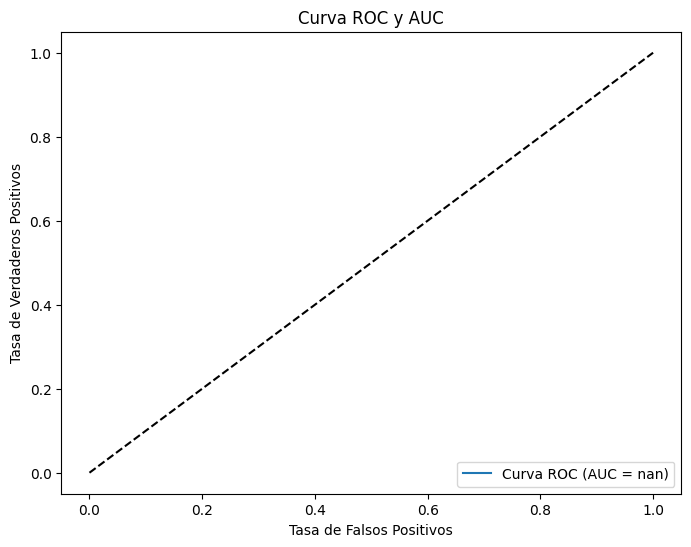

In [19]:
# Calcular y graficar la curva ROC-AUC
auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC y AUC")
plt.legend(loc="lower right")
plt.show()


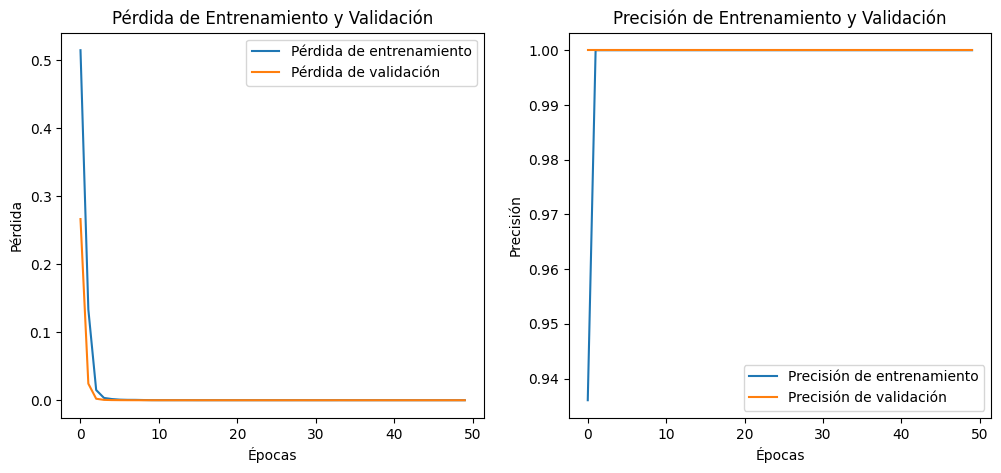

In [20]:
# Graficar la pérdida y precisión del modelo durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Pérdida de Entrenamiento y Validación")

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.title("Precisión de Entrenamiento y Validación")

plt.show()


Gráfico Izquierdo - Pérdida de Entrenamiento y Validación (Pérdida):

Representa la pérdida durante el entrenamiento y la validación a lo largo de épocas.
La pérdida de entrenamiento (línea azul) y la pérdida de validación (línea naranja) disminuyen bruscamente al principio y se estabilizan cerca de cero, lo que indica una buena convergencia.
Gráfico derecho - Precisión de Entrenamiento y Validación (Accuracy):

Representa la precisión durante el entrenamiento y la validación a lo largo de épocas.
La precisión del entrenamiento (línea azul) y la precisión de la validación (línea naranja) alcanzan rápidamente 1 (o 100%), lo que demuestra que el modelo funciona excepcionalmente bien en ambos conjuntos de datos.

licación de las métricas adicionales
Precision (Precisión) : Mide la proporción de verdaderos positivos entre todos los positivos predichos. Indica la exactitud de las predicciones positivas del modelo.

Recall (Sensibilidad) : Mide la proporción de verdaderos positivos entre todos los positivos reales. Indica la capacidad del modelo para identificar correctamente las instancias positivas.

Specificity (Especificidad) : Mide la proporción de verdaderos negativos entre todos los negativos reales. Indica la capacidad del modelo para identificar correctamente las instancias negativas.

F1-score : Es la media armónica entre la precisión y el retiro. Proporciona una métrica balanceada que considera tanto falsos positivos como falsos negativos.

AUC (Área Bajo la Curva ROC) : Representa la probabilidad de que el modelo clasifique correctamente una instancia positiva al azar. Un valor de AUC cercano a 1 indica un modelo excelente.

Matriz de Confusión : Es una tabla que permite visualizar el rendimiento del modelo al mostrar las predicciones correctas e incorrectas en cada clase.

Consideraciones adicionales
Balance de clases : Si tus datos están desbalanceados (una clase es mucho más frecuente que la otra), considera usar técnicas como ponderación de clases o submuestreo/sobremuestreo para equilibrar el conjunto de datos.

Umbral de clasificación : El umbral de 0,5 puede no ser óptimo. Puedes ajustar el umbral para maximizar métricas como el F1-score o la sensibilidad, dependiendo de las necesidades de tu aplicación.

Validación cruzada : Implementar validación cruzada puede proporcionar una evaluación más robusta del rendimiento del modelo.

Guardar y cargar el modelo : Si planeas reutilizar el modelo, considera guardar los pesos entrenados y el modelo completo.




In [21]:
# Generar predicciones
y_pred_prob = cnn_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcular métricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Calcular sensibilidad y especificidad
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Mostrar las métricas
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensibilidad): {recall:.2f}")
print(f"Specificity (Especificidad): {specificity:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

# Mostrar el informe de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)